# run CONFIG and other algorithms on a test instance sampled from GP

## import packages and set some parameter configurations

In [1]:
import numpy as np
import config
import matplotlib.pyplot as plt
import os
from copy import deepcopy
from copy import copy
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


optimization_config = {
    'eval_budget': 100
}

%load_ext autoreload
%autoreload 2

## sample the problem instance and set some utilities

In [3]:
base_opt_config = {
    'noise_level':0.0,
    'kernel_var':0.1,
    'train_noise_level': 0.0,
    'problem_name':'GP_sample_two_funcs'
}

def get_optimizer(optimizer_type, optimizer_config, problem_config):
    problem = config.OptimizationProblem(problem_config)
    if optimizer_type == 'safe_bo':
        opt = config.SafeBO(problem, optimizer_config)
        best_obj_list = [-opt.best_obj]
    if optimizer_type == 'constrained_bo':
        opt = config.ConstrainedEI(problem, optimizer_config)
        best_obj_list = [opt.best_obj]
    if optimizer_type == 'pdbo':
        opt = pdbo.PDBO(problem, optimizer_config)
        best_obj_list = [opt.best_obj]
    if optimizer_type == 'config':
        opt = config.CONFIGOpt(problem, optimizer_config)
        best_obj_list = [opt.best_obj]
    total_cost_list = []
    return opt, best_obj_list, total_cost_list

# try running config opt step by step

In [102]:
problem_config = config.get_config('GP_sample_single_func')
obj_vals_arr = problem_config['obj'](problem_config['parameter_set'])
constr_vals_arr = problem_config['constrs_list'][0](problem_config['parameter_set'])
f_min = problem_config['f_min']
f_min_id = np.argmin(obj_vals_arr)
f_max = np.max(obj_vals_arr)
print(problem_config['f_min'])

# Initialize the config optimizer
configOpt_config = base_opt_config.copy()
configOpt_config.update({
        'total_eval_num': 20,
    }
)
config_opt, configOpt_best_obj_list, configOpt_total_cost_list = get_optimizer(
            'config', configOpt_config, problem_config)
config_opt_obj_list = []
config_opt_constr_list = []

# Initialize SafeOPT
SafeOpt_config = base_opt_config.copy()
SafeOpt_config.update({
        'total_eval_num': 20,
    }
)
safe_opt, SafeOpt_best_obj_list, SafeOpt_total_cost_list = get_optimizer(
            'safe_bo', SafeOpt_config, problem_config)
safe_opt_obj_list = []
safe_opt_constr_list = []

# Initialize CEI
CEIOpt_config = base_opt_config.copy()
CEIOpt_config.update({
        'total_eval_num': 20,
    }
)
CEI_opt, CEI_Opt_best_obj_list, CEIOpt_total_cost_list = get_optimizer(
            'constrained_bo', CEIOpt_config, problem_config)
cei_opt_obj_list = []
cei_opt_constr_list = []

cumu_pos_subopt_config = []
cumu_pos_vio_config = []

cumu_pos_subopt_safe = []
cumu_pos_vio_safe = []


-3.602032849177249


# run the following cell repeatedly to see the sampling process of the CONFIG algorithm

[[0.80023024]] [[0.80023024]]
[[1.33475182]] [[1.33475182]]
[[0.61654382]] [[0.61654382]]
[[0.76805429]] [[0.76805429]]
[[1.05721908]] [[1.05721908]]
[[0.54641079]] [[0.54641079]]
[[0.38738956]] [[0.38738956]]
[[0.21329725]] [[0.21329725]]
[[0.23106083]] [[0.23106083]]
[[0.23188715]] [[0.23188715]]
[[1.33475182]] [[1.33475182]]
[[1.33475182]] [[1.33475182]]
[[1.33475182]] [[1.33475182]]
[[1.33475182]] [[1.33475182]]
[[1.33475182]] [[1.33475182]]
[[1.33475182]] [[1.33475182]]
[[1.33475182]] [[1.33475182]]
[[1.33475182]] [[1.33475182]]
[[1.33475182]] [[1.33475182]]
[[1.33475182]] [[1.33475182]]


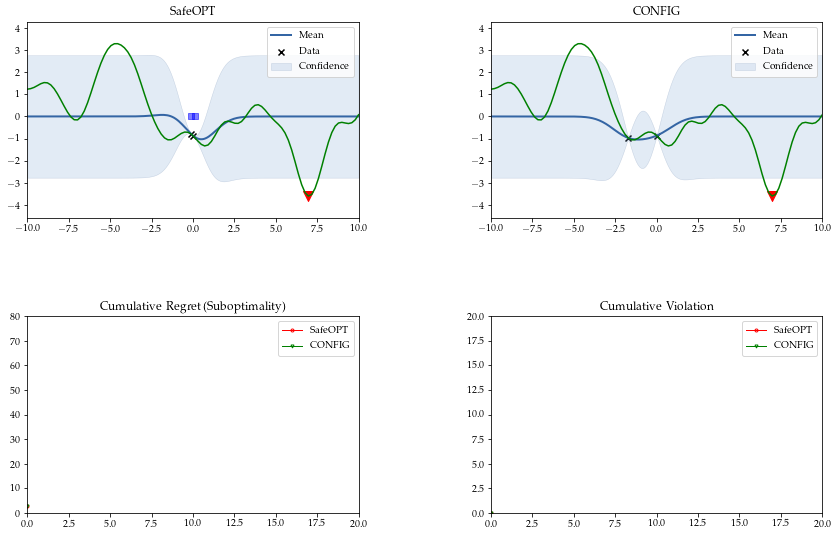

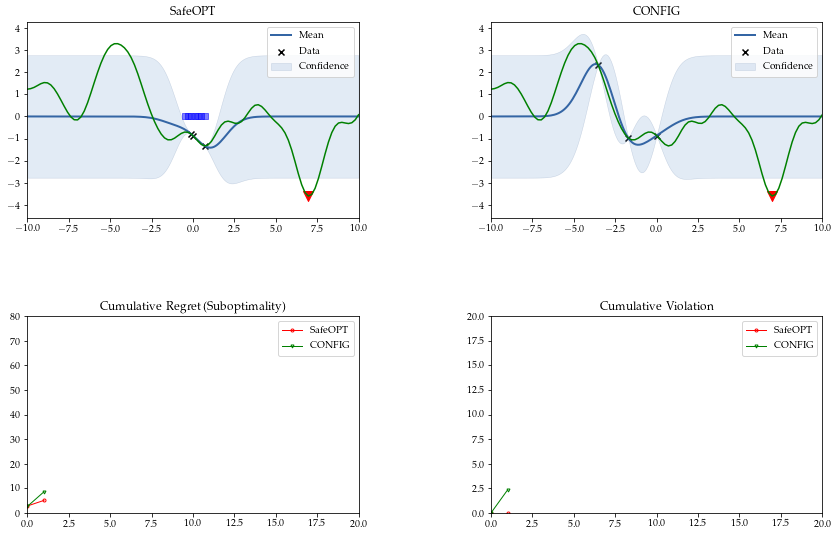

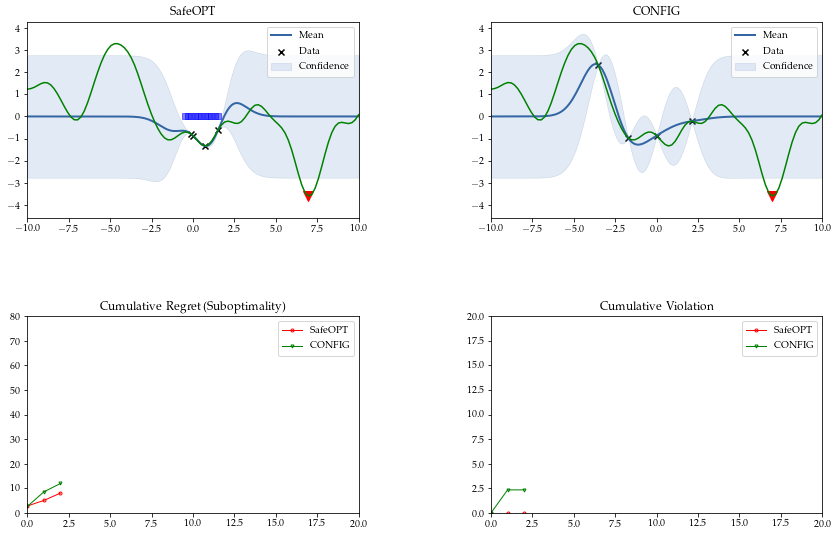

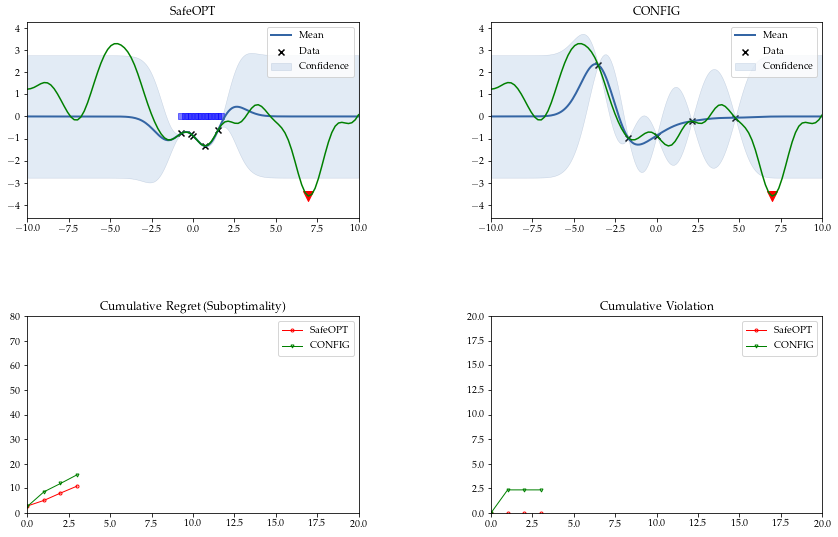

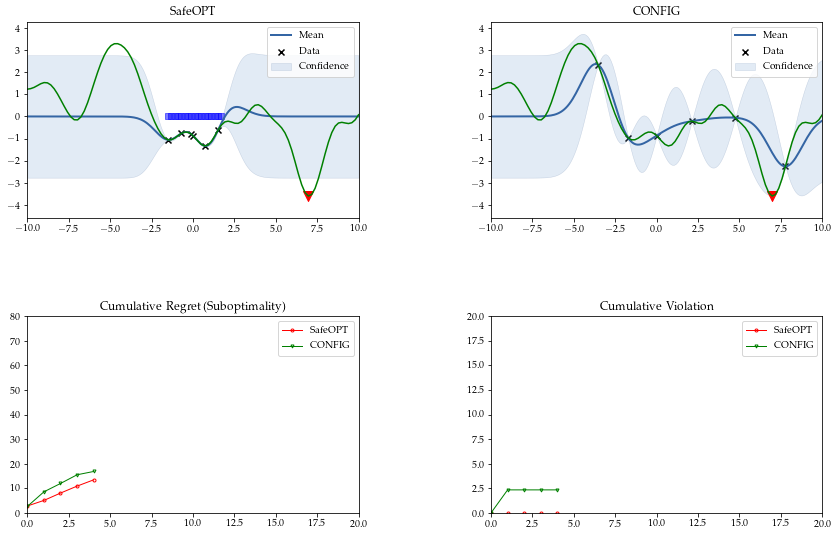

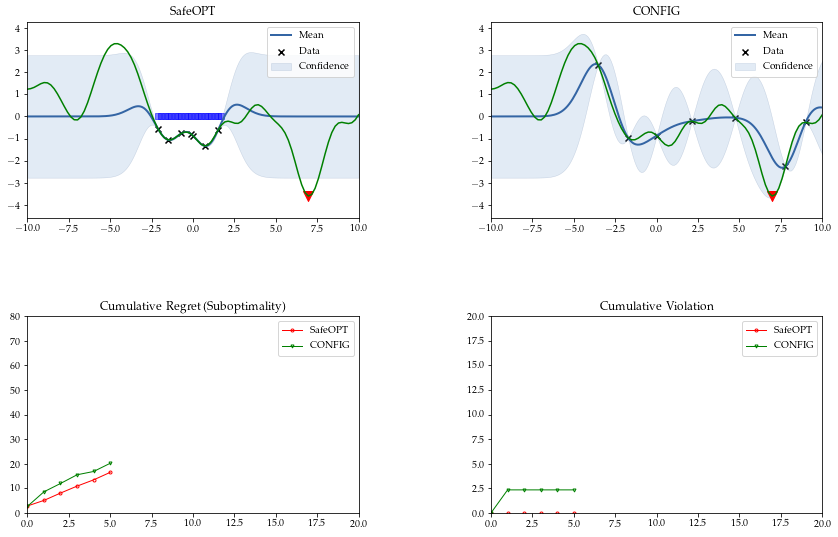

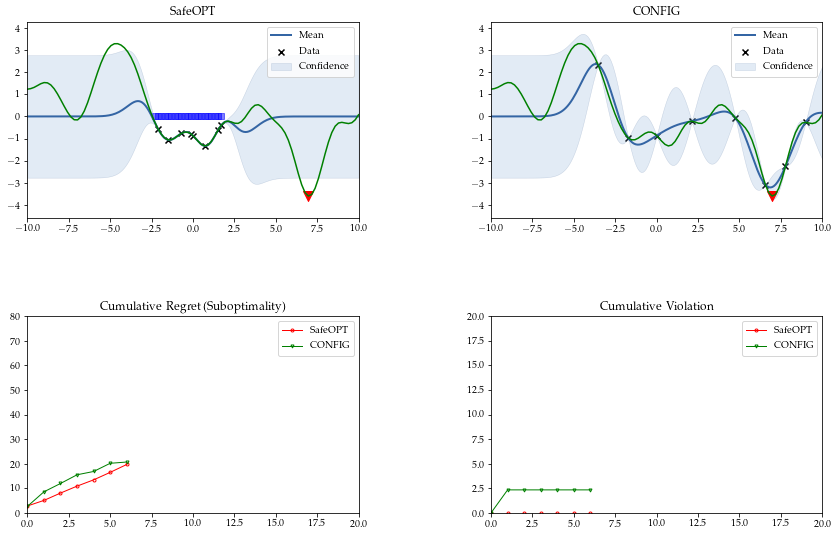

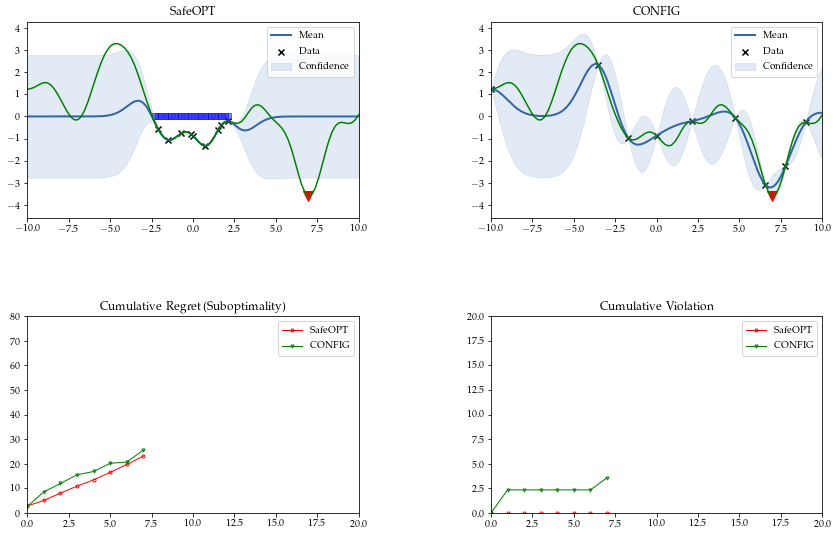

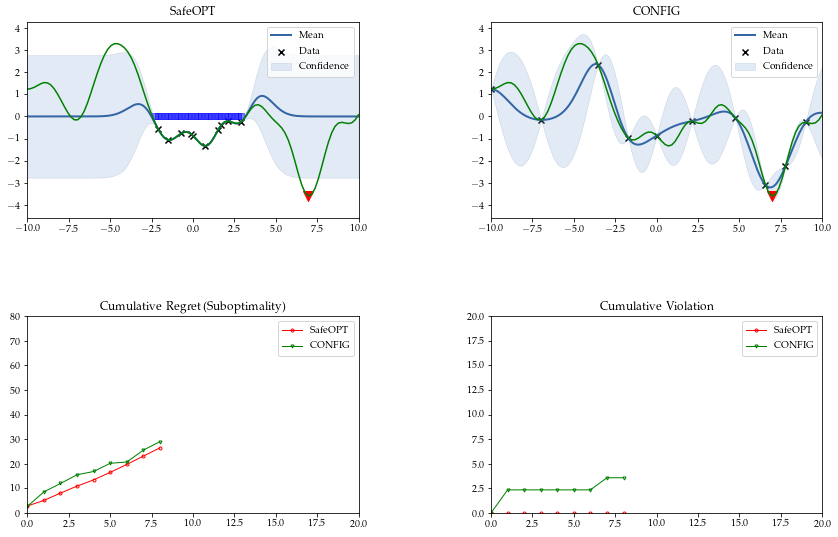

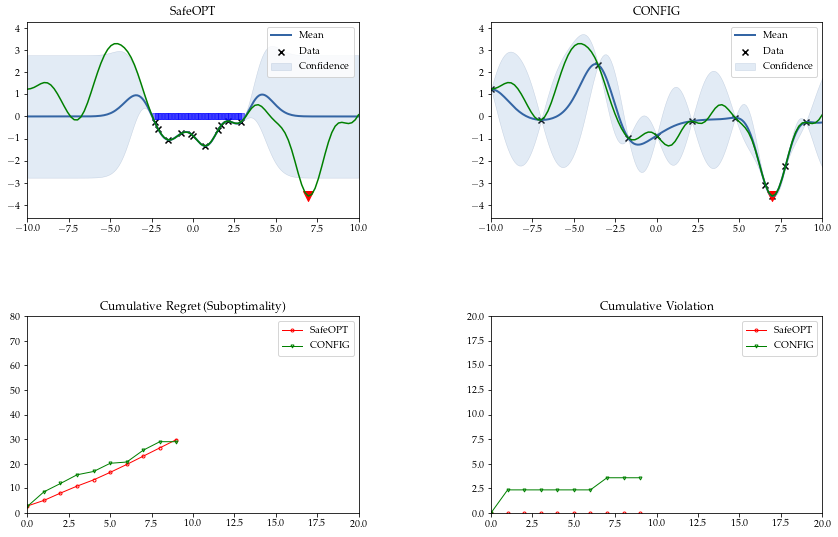

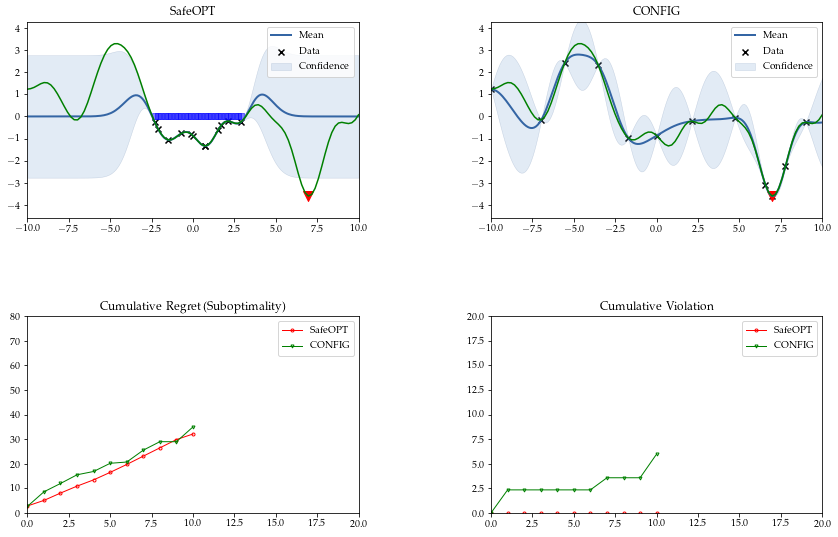

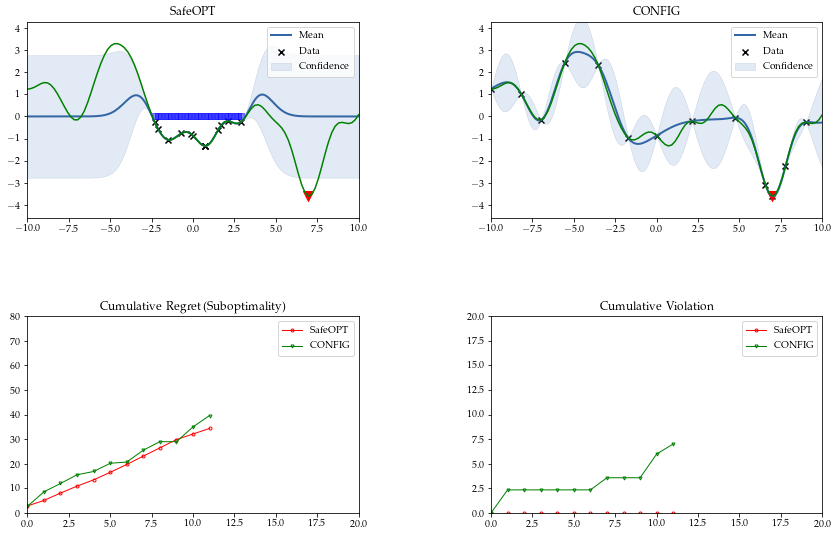

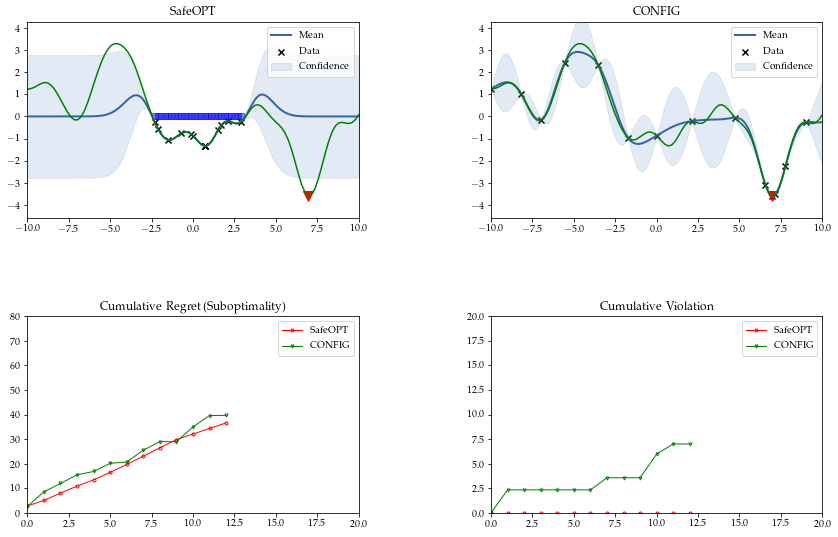

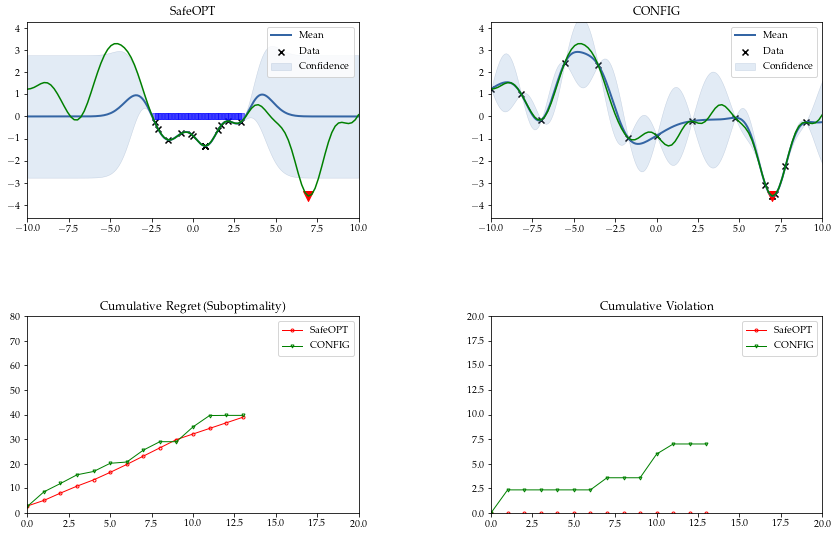

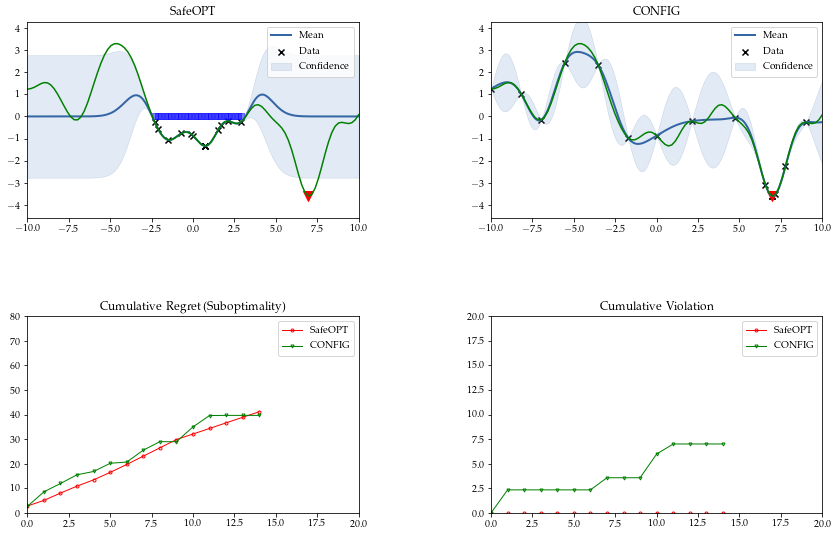

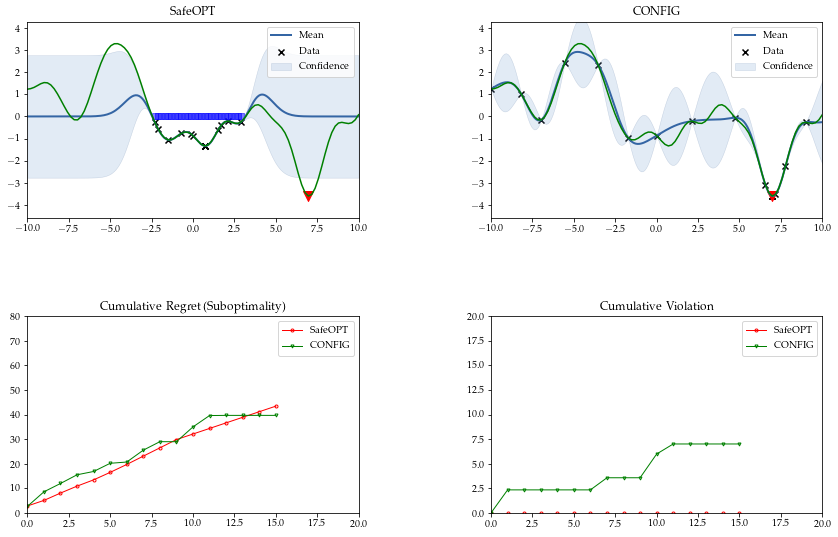

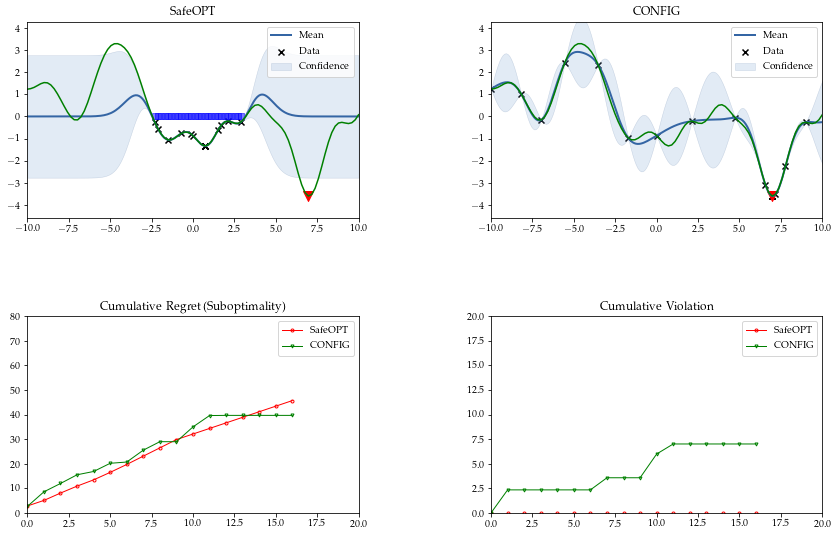

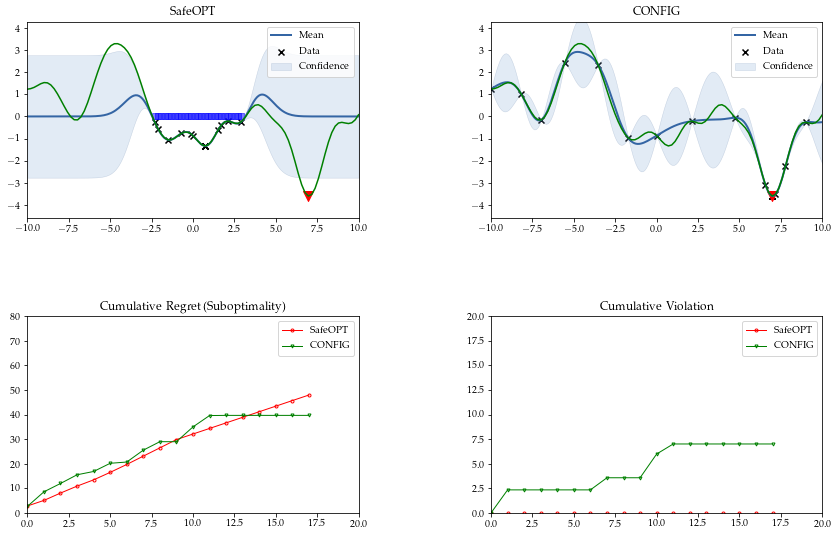

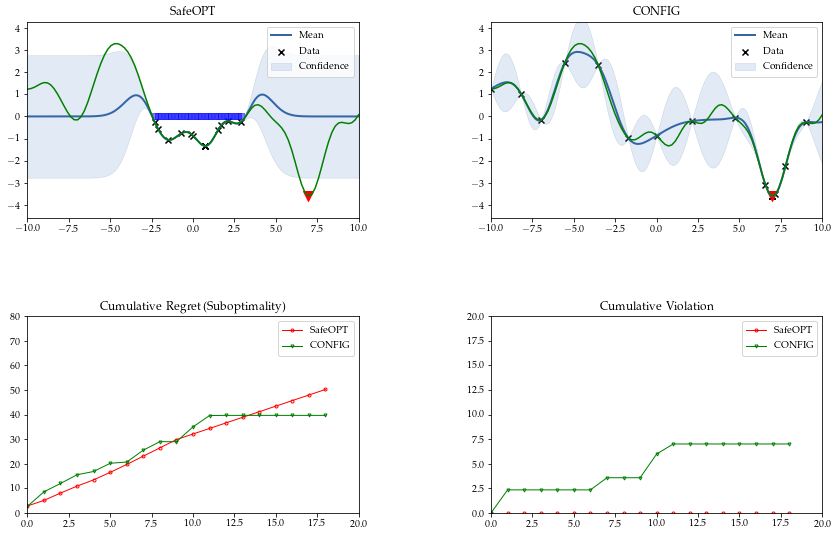

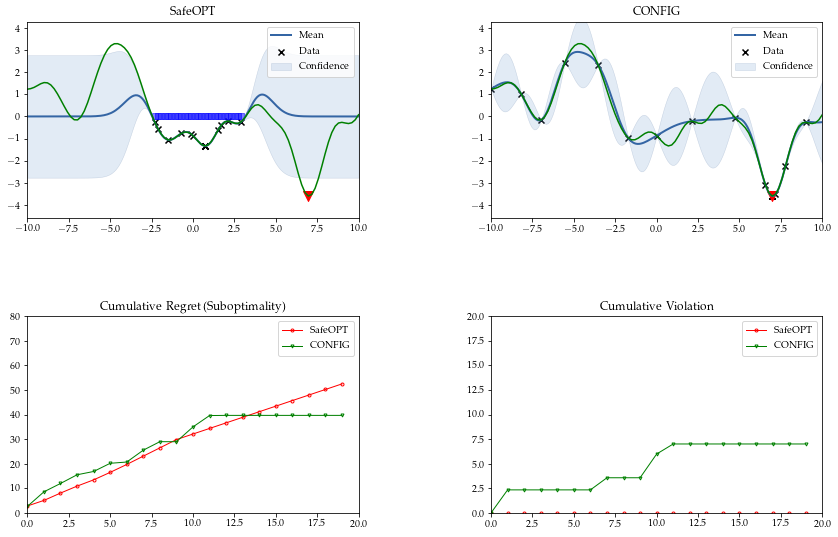

In [103]:
colors = ['red','purple', 'orange', 'green', 'blue', 'black', 'blue']
marksCur = ['o','s', '*', 'v', '^','+']
Run_steps = 20

for _ in range(Run_steps):
    if True:
        y_obj, constr_vals = config_opt.make_step()
        config_opt_obj_list.append(y_obj[0, 0])
        config_opt_constr_list.append([constr_vals[0, k] for k in range(problem_config['num_constrs'])])
        
        cumu_pos_subopt_config.append(max(y_obj[0,0]-f_min,0))
        cumu_pos_vio_config.append(max(constr_vals[0,0],0))
        
        y_obj, constr_vals = safe_opt.make_step()
        safe_opt_obj_list.append(y_obj[0, 0])
        safe_opt_constr_list.append([constr_vals[0, k] for k in range(problem_config['num_constrs'])])
        print(y_obj, constr_vals)
        cumu_pos_subopt_safe.append(max(-y_obj[0,0]-f_min,0))
        cumu_pos_vio_safe.append(max(-constr_vals[0,0],0))
        
        
        y_obj, constr_vals = CEI_opt.make_step()
        cei_opt_obj_list.append(y_obj[0, 0])
        cei_opt_constr_list.append([constr_vals[0, k] for k in range(problem_config['num_constrs'])])
        
    if True:
        
        
        from fig_hp import *
        fig, axes = plt.subplots(2, 2)
        fig.set_size_inches(WIDTH * 2.4 * 2, HEIGHT * 2.4 * 2)

        fig.subplots_adjust(left=.22, bottom=.20, right=.99, top=.97, hspace=0.5, wspace=0.4) 
   
        ax = axes[0, 0]
        
        gp_obj_inv = copy(safe_opt.gp_obj)
        gp_obj_inv.set_Y(-gp_obj_inv.Y)
        gp_obj_inv.plot(plot_limits=(-10, 10), ax=ax)
        ax.plot(np.squeeze(problem_config['parameter_set']), obj_vals_arr, color='g')
        ax.scatter(problem_config['parameter_set'][f_min_id], f_min, 100, color='r', marker='v')
        ax.set_title('SafeOPT')
        #plt.savefig(f'./figs/safe_1d_example.png', format='png', dpi=300)
        ax.set_ylim((f_min-1, max(f_max+1, 3.5)))
        safe_x = safe_opt.parameter_set[safe_opt.opt.S].squeeze()
        ax.scatter(safe_x, np.zeros(len(safe_x)), alpha=0.5, color='b', marker='s')
        
        
        ax = axes[0, 1]
        config_opt.gp_obj.plot(plot_limits=(-10, 10), ax=ax)
        ax.plot(np.squeeze(problem_config['parameter_set']), obj_vals_arr, color='g')
        ax.scatter(problem_config['parameter_set'][f_min_id], f_min, 100, color='r', marker='v')
        ax.set_title('CONFIG')
        ax.set_ylim((f_min-1, max(f_max+1, 3.5)))
        #plt.savefig(f'./figs/config_1d_example.png', format='png', dpi=300)
        
        ax = axes[1, 0]
        #print(cumu_pos_subopt_safe)
        ax.plot(np.arange(len(cumu_pos_subopt_safe)), np.cumsum(cumu_pos_subopt_safe),
                linewidth=LINEWIDTH, color=colors[0], marker=marksCur[0], markerfacecolor='None', markersize=MARKERSIZE)
        
        ax.plot(np.arange(len(cumu_pos_subopt_safe)), np.cumsum(cumu_pos_subopt_config),
                linewidth=LINEWIDTH, color=colors[3], marker=marksCur[3], markerfacecolor='None', markersize=MARKERSIZE)
        
        ax.set_title('Cumulative Regret (Suboptimality)')
        ax.set_xlim((0, Run_steps))
        ax.set_ylim((0, 80))
        ax.legend(['SafeOPT', 'CONFIG'])
        
        ax = axes[1, 1]
        ax.plot(np.arange(len(cumu_pos_subopt_safe)), np.cumsum(cumu_pos_vio_safe),
                linewidth=LINEWIDTH, color=colors[0], marker=marksCur[0], markerfacecolor='None', markersize=MARKERSIZE)
        
        ax.plot(np.arange(len(cumu_pos_subopt_safe)), np.cumsum(cumu_pos_vio_config),
                linewidth=LINEWIDTH, color=colors[3], marker=marksCur[3], markerfacecolor='None', markersize=MARKERSIZE)
        
        ax.set_title('Cumulative Violation')
        ax.set_xlim((0, Run_steps))
        ax.set_ylim((0, 20))
        ax.legend(['SafeOPT', 'CONFIG'])
        plt.savefig(f'./figs/compare_1d_{_}.png', format='png', bbox_inches='tight', dpi=300)
#         CEI_opt.gp_obj.plot(plot_limits=(-10,10))
#         plt.plot(np.squeeze(problem_config['parameter_set']), obj_vals_arr, color='g')
#         plt.scatter(problem_config['parameter_set'][f_min_id], f_min, 100, color='r', marker='v')
#         plt.title('CEI')
#         plt.savefig(f'./figs/cei_1d_example.png', format='png', dpi=300)
#         plt.ylim((f_min-1.5, f_max+1))

In [89]:
safe_opt.parameter_set[safe_opt.opt.S]

array([[-1.91919192],
       [-1.71717172],
       [-1.51515152],
       [-1.31313131],
       [-1.11111111],
       [-0.90909091],
       [-0.70707071],
       [-0.50505051],
       [-0.3030303 ],
       [-0.1010101 ],
       [ 0.1010101 ],
       [ 0.3030303 ],
       [ 0.50505051],
       [ 0.70707071],
       [ 0.90909091],
       [ 1.11111111],
       [ 1.31313131],
       [ 1.51515152],
       [ 1.71717172],
       [ 1.91919192],
       [ 2.12121212],
       [ 2.32323232],
       [ 2.52525253],
       [ 2.72727273],
       [ 2.92929293],
       [ 3.13131313],
       [ 3.33333333],
       [ 3.53535354]])

# plot the constrained regret $\min_{t\in[T]}[f(x_t)-f^*]^++[g(x_t)]^+$
# When it converges to 0, the optimal solution is found.

In [109]:
def get_con_regret(obj_list, constr_list):
    obj_arr = np.array(obj_list)
    constr_arr = np.array(constr_list)
    pos_regret_arr = np.maximum(obj_arr-problem_config['f_min'],0)
    pos_constr_arr = np.maximum(constr_arr, 0)
    return np.minimum.accumulate(pos_regret_arr+np.sum(pos_constr_arr, axis=1))

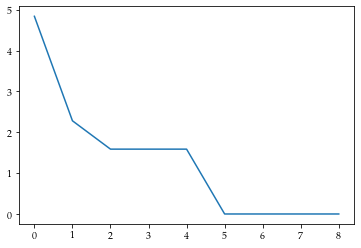

In [110]:
constr_regret = get_con_regret(config_opt_obj_list, config_opt_constr_list)
plt.plot(constr_regret)